# Lecture 2.2: Damped Harmonic Oscillator

One of the most common examples of a second-order ODE is the damped harmonic oscillator. Damped Oscillations. The force on the block from the spring is $F_s = −kx$, and the damping force is $F_d = −bv$.
Assuming that the gravitational force on the block is negligible relative to the force from the spring.
Its solution is given by:

$$ 
    x(t) = x_m e^{-\frac{b}{2m}t} \cos(\omega' t + \phi)
$$
where $x_m$ is the amplitude of the oscillations, $b$ is the damping coefficient, $m$ is the mass, $\omega'$ is the angular frequency, and $\phi$ is the phase angle. The angular frequency is given by
$$
    \omega' = \sqrt{\omega_0^2 - \left(\frac{b}{2m}\right)^2}
$$
where $\omega_0$ is the natural frequency of the oscillator, $k$ is the spring constant.

### Importing the required libraries
Again we import the required libraries and set the plotting style. Here we import also the class `ProblemSpec` to set a problem specification to run the sensitivity analysis and propagate the uncertainties for the same given specification.

In [1]:
from SALib.sample.sobol import sample
from SALib.analyze import sobol
from SALib import ProblemSpec
import numpy as np
import matplotlib.pyplot as plt

# set font as Stix 
plt.rcParams["mathtext.fontset"] = "stix"

### Defining the damped oscillator function

In this example we gonna study a time dependent algebraic function to analyze how the SA runs along an axis and how it can be visualized.
Again using the Python package `numpy` we define the model problem to be studied. For this case we will construct our function to return an array of values in function of time. 

So, if we want to get it randomized we need another method that wraps the previous one and returns a matrix given random values of the inputs. Or even we can do it simple and use a list comprehension strategy to get the desired result, but let's save this second approach for later.

First, define our studied function:


In [2]:
def damped_oscillator(t, b, m, w0, phi):
    w = np.sqrt(w0**2 - (b/(2*m))**2)
    return np.exp(-b*t/(2*m)) * np.cos(w*t - phi)

And let's visualize the output for a given set of reference values.

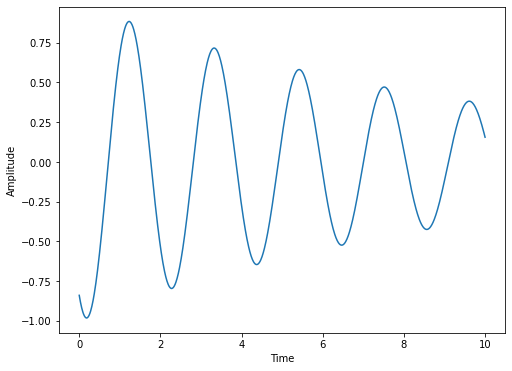

In [3]:
t = np.linspace(0, 10, 1000)
b = 2
m = 10
w0 = 3
phi = 10

# plot the damped oscillator
plt.figure(figsize=(8, 6))
plt.plot(t, damped_oscillator(t, b, m, w0, phi))
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

Now, let's define our wrapped function to work with the sensitivity analysis.

In [4]:
def wrapped_damped_oscillator(rv_params, t=t):
    y = np.zeros((rv_params.shape[0], len(t)))
    for i, (b, m, w0, phi) in enumerate(rv_params):
        y[i, :] = damped_oscillator(t, b, m, w0, phi)
    return y

### Defining the Analysis Problem

In this problem we gonna use Gaussian/normal distributions to define the uncertainties of the inputs. So the mean will exaclty the same as our reference values and the standard deviation will be $\alpha \%$ of the mean.

In [5]:
alpha = 0.03

problem = {
    'num_vars': 4,
    'names': ['b', 'm', 'w0', 'phi'],
    'bounds': [[b, alpha*b], [m, alpha*m], [w0, alpha*w0], [phi, alpha*phi]],
    'dists': ['norm', 'norm', 'norm', 'norm']
}

# param_values = sample(problem, 1024)
# Ys = np.array([damped_oscillator(t, *p) for p in param_values])
# Sis = [sobol.analyze(problem, Y, conf_level=0.95) for Y in Ys.T]

sp = ProblemSpec(problem)

sp.sample_sobol(2**8) \
    .evaluate(wrapped_damped_oscillator) \
    .analyze_sobol()

S1s = np.array([sp.analysis[_y]['S1'] for _y in sp['outputs']])
STs = np.array([sp.analysis[_y]['ST'] for _y in sp['outputs']])

evaluations = sp.results

### Output Visualization and Analysis

For this time dependent case we have a list of dictionaries, where each dictionary has the Sobol indices for each time step, i.e., each dict is as our first non time dependent example. 

#### Sensitivity Analysis

To put in perspective the output and its sensitivity, let's plot the results of the sensitivity analysis (first- and total-order Sobol indices) together with the output of the model.

In [6]:
# defining colors and latex symbols for plotting
colors = ['red', 'blue', 'green', 'orange']
latex_symbols = {'b': 'b',
              'm': 'm',
              'w0': r'\omega_0',
              'phi': r'\phi'}

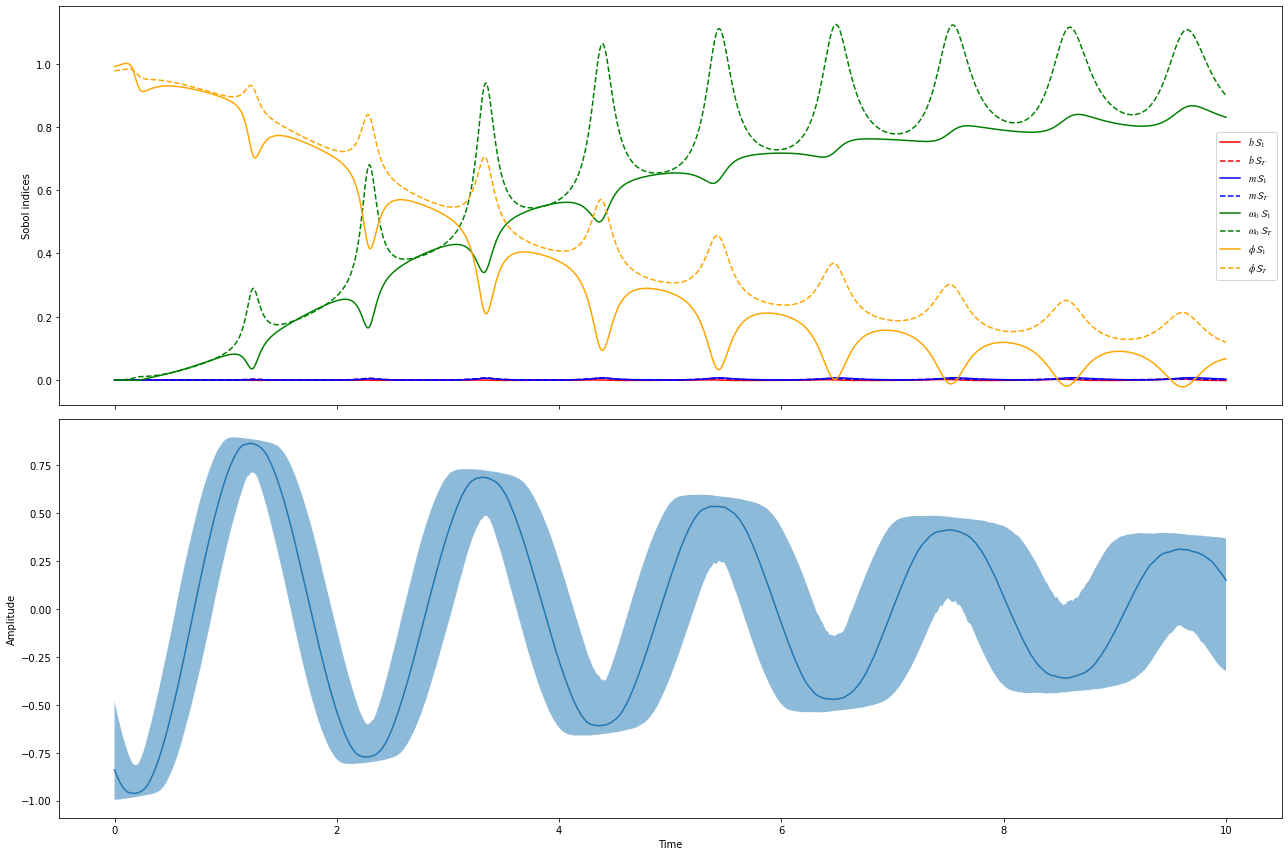

In [48]:
fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True, figsize=(18, 12))
for i, key in enumerate(problem['names']):
    ax0.plot(t, S1s[:,i], label=rf'${latex_symbols[key]}\, \mathcal{{S}}_1$', color=colors[i])
    ax0.plot(t, STs[:,i], '--', label=rf'${latex_symbols[key]}\, \mathcal{{S}}_T$', color=colors[i])
ax0.set_ylabel('Sobol indices')
ax0.legend()

median = np.median(evaluations, axis=0)
upper = np.percentile(evaluations, 95, axis=0)
lower = np.percentile(evaluations, 5, axis=0)
ax1.plot(t, median, label='median')
ax1.fill_between(t, lower, upper, alpha=0.5, label='95% confidence interval')
ax1.set_xlabel('Time')
ax1.set_ylabel('Amplitude')
plt.tight_layout()
plt.show()

We can see that the phase angle $\phi$ has the greatest impact on the model output in the beggining of the damped oscillations, but as the time goes by the impact of the phase angle decreases and the natural frequency $\omega_0$ becomes the most significative input.

Also, at the highest amplitudes it is possible to see great interactions between theses two inputs.

___

### Sensitivity Around another Mean Value

Let's analyze the model with another configuration to see how the SA behaves. Basically we ganna change the reference values reducing the phase angle $\phi$ and the mass $m$.

In [49]:
t = np.linspace(0, 10, 1000)
b = 2
m = 1
w0 = 3
phi = 1

alpha = 0.03

problem = {
    'num_vars': 4,
    'names': ['b', 'm', 'w0', 'phi'],
    'bounds': [[b, alpha*b], [m, alpha*m], [w0, alpha*w0], [phi, alpha*phi]],
    'dists': ['norm', 'norm', 'norm', 'norm']
}

sp = ProblemSpec(problem)

sp.sample_sobol(2**8) \
    .evaluate(wrapped_damped_oscillator) \
    .analyze_sobol()

S1s = np.array([sp.analysis[_y]['S1'] for _y in sp['outputs']])
STs = np.array([sp.analysis[_y]['ST'] for _y in sp['outputs']])

evaluations = sp.results

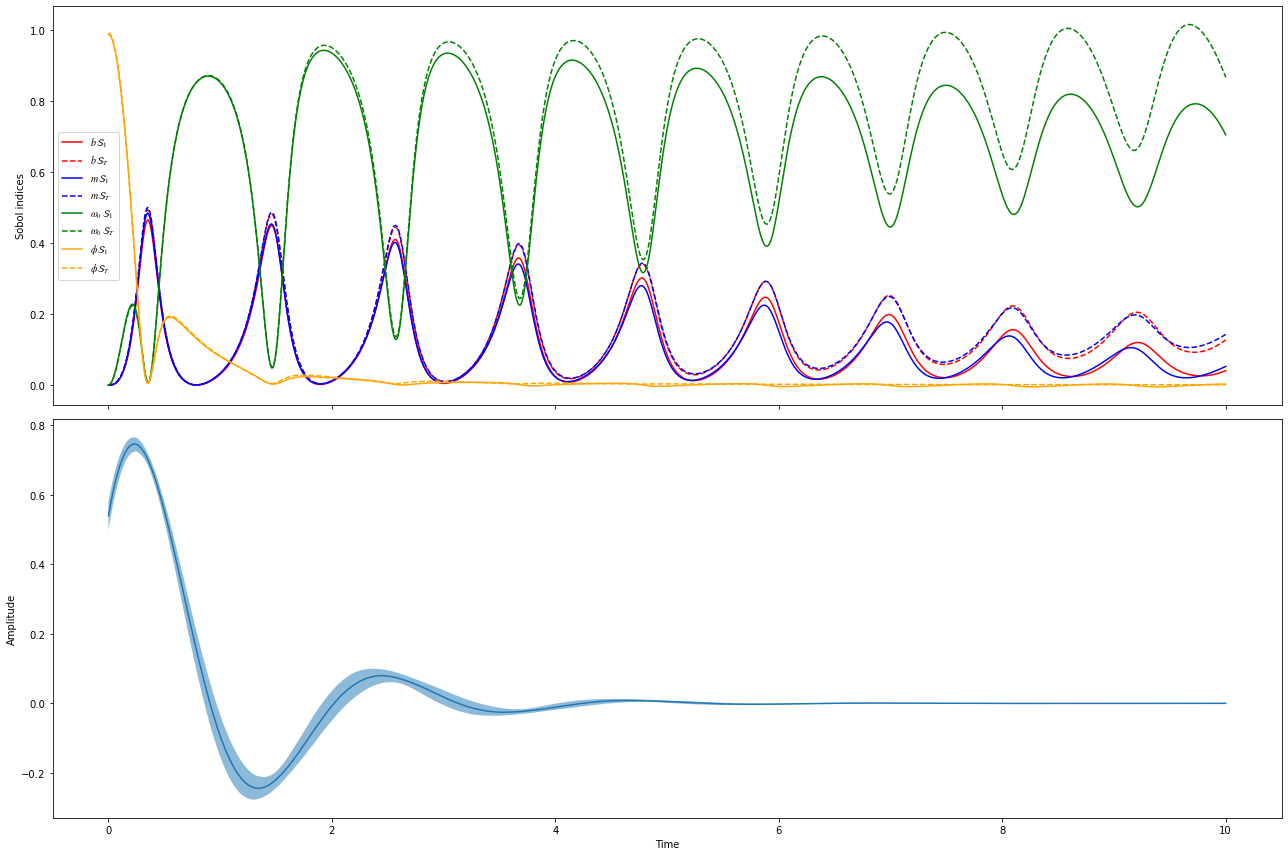

In [50]:
fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True, figsize=(18, 12))
for i, key in enumerate(problem['names']):
    ax0.plot(t, S1s[:,i], label=rf'${latex_symbols[key]}\, \mathcal{{S}}_1$', color=colors[i])
    ax0.plot(t, STs[:,i], '--', label=rf'${latex_symbols[key]}\, \mathcal{{S}}_T$', color=colors[i])
ax0.set_ylabel('Sobol indices')
ax0.legend()

median = np.median(evaluations, axis=0)
upper = np.percentile(evaluations, 95, axis=0)
lower = np.percentile(evaluations, 5, axis=0)
ax1.plot(t, median, label='median')
ax1.fill_between(t, lower, upper, alpha=0.5, label='95% confidence interval')
ax1.set_xlabel('Time')
ax1.set_ylabel('Amplitude')
plt.tight_layout()
plt.show()

<span style="color:blue">*Critical Reasoning about the results.*</span> 

___
### References

[1] Saltelli, A., Ratto, M., Andres, T., Campolongo, F., Cariboni, J., Gatelli, D., Saisana, M., Tarantola, S., (2008). Global Sensitivity Analysis: The Primer. John Wiley & Sons, Ltd, Chichester, UK.

[2] Walker, J., Resnick, R., & Halliday, D. (2022). Fundamentals of Physics. Wiley. John Wiley & Sons.